In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os

In [2]:
_nCH=64
_vmin=30.0
_vmax=50.0
#
_name_pref_list=['../SiPM/FBK_sipm_tiles_terzina/Terzina_Tiles01/Terzina_Tiles01/20240528_IV_tile_01/CH',
                 '../SiPM/FBK_sipm_tiles_terzina/Terzina_Tiles02/Terzina_Tiles02/20240611_IV_tile_02/CH',
                 '../SiPM/FBK_sipm_tiles_terzina/Terzina_Tiles04/Terzina_Tiles04/20240618_IV_tile_04/CH',
                 '../SiPM/FBK_sipm_tiles_terzina/Terzina_Tiles05/Terzina_Tiles05/20240620_IV_tile_05/CH',
                 '../SiPM/FBK_sipm_tiles_terzina/Terzina_Tiles06/Terzina_Tiles06/20240624_IV_tile_06/CH']
_tile_ID_list=['01','02','04','05','06']
#
_name_pref=_name_pref_list[0]

In [3]:
# Function to read the first line of the file and extract values of time, temperature and humidity
def read_first_line(path_to_file):
    with open(path_to_file, 'r') as file:
        # Read the first line
        first_line = file.readline().strip()
        
        # Remove the leading '#' character
        first_line = first_line.lstrip('#')
        
        # Split the line into parts based on commas
        parts = first_line.split(',')
        
        # Extract the time, temperature, and humidity
        time = datetime.datetime.strptime(parts[0].strip(), '%Y-%m-%d %H:%M:%S.%f')
        temp = parts[1].replace('Temp:', '').strip().replace('°C', '')
        humidity = parts[2].replace('Humi:', '').strip().replace('%', '')
        
        return time, temp, humidity
        
# Calculate the truncated average for each row
def truncated_mean(row):
    # Drop NaN values
    row = row.dropna()
    #removing min and max before average
    current_values = row[1:].tolist()
    current_values.remove(min(current_values))
    current_values.remove(max(current_values))
    # Calculate the mean
    return np.mean(current_values)


def readingOneFile(path_to_file):
    # reade the file
    VI_1col = pd.read_csv(path_to_file, delimiter=',', skiprows=1)

    # Reshape the data
    VI = VI_1col.pivot_table(index='Sourced_voltage', 
                             columns=VI_1col.groupby('Sourced_voltage').cumcount(), 
                             values='Channel_Current').reset_index()
    
    # Apply the truncated_mean function to each row
    VI['Current_Average'] = VI.iloc[:].apply(truncated_mean, axis=1)

    dictionary ={'Time':read_first_line(path_to_file)[0],
                'Temperature':float(read_first_line(path_to_file)[1]),
                'Humidity':float(read_first_line(path_to_file)[2]),
                'VI_table':VI}
    return dictionary

def plottingOneIVCurve(df, boarder_index_ForwardReverse):
    # boarder_index_ForwardReverse = how many points you have in the forward region
    boarder = boarder_index_ForwardReverse
    
    fig, ax = plt.subplots(1,2, figsize=(15,7), width_ratios=[2, 3])
    fig.suptitle('Time: %s, Temp: %d°C, Hum: %d%%' % (df['Time'], df['Temperature'], df['Humidity']), fontsize=14)
    pd = df['VI_table']
    
    ax[0].plot(abs(pd['Sourced_voltage'][:boarder]), pd['Current_Average'][:boarder], 'o-')    
    ax[0].grid(axis='y', color='0.90')
    ax[0].grid(axis='x', color='0.90')
    ax[0].set_xlabel("Voltage (V)", fontsize=14)
    ax[0].set_ylabel("Current (A)", fontsize=14)
    ax[0].set_title("Forward IV curve", fontsize=14)

    ax[1].plot(pd['Sourced_voltage'][boarder:], abs(pd['Current_Average'][boarder:]), 'o-')
    ax[1].grid(axis='y', color='0.90')
    ax[1].grid(axis='x', color='0.90')
    ax[1].set_xlabel("Voltage (V)", fontsize=14)
    # ax[1].set_ylabel("Current (A)", fontsize=14)
    ax[1].set_title("Reverse IV curve", fontsize=14)
    ax[1].set_yscale('log')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()


def plottingListIVCurve(df, boarder_index_ForwardReverse, CH_list):
    # boarder_index_ForwardReverse = how many points you have in the forward region
    boarder = boarder_index_ForwardReverse
    
    fig, ax = plt.subplots(1,2, figsize=(15,7), width_ratios=[2, 3])
    #fig.suptitle('Time: %s, Temp: %d°C, Hum: %d%%' % (df['Time'], df['Temperature'], df['Humidity']), fontsize=14)

    for onedf, l in zip(df,CH_list):
        pd = onedf['VI_table']
        ax[0].plot(abs(pd['Sourced_voltage'][:boarder]), pd['Current_Average'][:boarder], 'o-', label=l)
        ax[1].plot(pd['Sourced_voltage'][boarder:], abs(pd['Current_Average'][boarder:]), 'o-', label=l)
        
    ax[0].grid(axis='y', color='0.90')
    ax[0].grid(axis='x', color='0.90')
    ax[0].set_xlabel("Voltage (V)", fontsize=14)
    ax[0].set_ylabel("Current (A)", fontsize=14)
    ax[0].set_title("Forward IV curve", fontsize=14)
    ax[0].legend()

    ax[1].grid(axis='y', color='0.90')
    ax[1].grid(axis='x', color='0.90')
    ax[1].set_xlabel("Voltage (V)", fontsize=14)
    # ax[1].set_ylabel("Current (A)", fontsize=14)
    ax[1].set_title("Reverse IV curve", fontsize=14)
    ax[1].set_yscale('log')
    ax[1].set_xlim(30,42.5)
    ax[1].set_ylim(1.0e-9,3.0e-6)
    ax[1].legend()

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    

def load_data(thename = _name_pref):
    dfl=[]
    for i in np.arange(_nCH):
        name_pref=thename
        name=str(name_pref + str(i) + '.csv')
        if os.path.exists(name):
            dfl.append(pd.read_csv(name,sep=';'))
        else:
            dfl.append(np.nan)
    return dfl

def plot_df( df, vmin=_vmin, vmax=_vmax):
    if (str(type(df)) == '<class \'pandas.core.frame.DataFrame\'>'):        
        x=df[(df['CH1 Voltage']>=vmin) & (df['CH1 Voltage']<=vmax)]['CH1 Voltage']
        y=df[(df['CH1 Voltage']>=vmin) & (df['CH1 Voltage']<=vmax)]['CH1 Current']
        plt.scatter(x=x,y=y,alpha=0.2)
        plt.yscale('log')
        plt.grid(True)
        
def get_mean_curr_val( df, vmin=20, vmax=30):
    if (str(type(df)) == '<class \'pandas.core.frame.DataFrame\'>'):        
        x=df[(df['CH1 Voltage']>=vmin) & (df['CH1 Voltage']<=vmax)]['CH1 Voltage']
        y=df[(df['CH1 Voltage']>=vmin) & (df['CH1 Voltage']<=vmax)]['CH1 Current']
        return np.mean(y)
    return np.nan

def get_low_high_mean_and_ratio(dfl):
    mean_low=np.array([get_mean_curr_val( dfl[i], vmin=23, vmax=24) for i in np.arange(_nCH)])
    mean_high=np.array([get_mean_curr_val( dfl[i], vmin=34, vmax=35) for i in np.arange(_nCH)])
    ratio=mean_high/mean_low
    return mean_low, mean_high, ratio

In [4]:
df = readingOneFile("./data/FBK_TILE01_CH57_15.07.2024-16:42:11.txt") 
df

{'Time': datetime.datetime(2024, 7, 15, 16, 42, 18, 507176),
 'Temperature': 26.3,
 'Humidity': 54.3,
 'VI_table':     Sourced_voltage             0             1             2             3  \
 0              -1.5  7.780170e-04  7.780240e-04  7.780150e-04  7.780180e-04   
 1              -1.4  6.942460e-04  6.942460e-04  6.942470e-04  6.942430e-04   
 2              -1.3  6.108690e-04  6.108590e-04  6.108560e-04  6.108520e-04   
 3              -1.2  5.279930e-04  5.280130e-04  5.280090e-04  5.279850e-04   
 4              -1.1  4.458370e-04  4.458350e-04  4.458410e-04  4.458270e-04   
 ..              ...           ...           ...           ...           ...   
 86             41.2 -5.941220e-07 -6.000520e-07 -6.076240e-07 -6.339880e-07   
 87             41.4 -6.871880e-07 -7.277560e-07 -6.891830e-07 -6.856990e-07   
 88             41.6 -7.666720e-07 -7.675830e-07 -7.652880e-07 -7.501020e-07   
 89             41.8 -8.872040e-07 -8.741900e-07 -8.619600e-07 -8.628940e-07   
 90   

In [5]:
df['Time'], df['Temperature'], df['Humidity']

(datetime.datetime(2024, 7, 15, 16, 42, 18, 507176), 26.3, 54.3)

In [6]:
df['VI_table']

,Sourced_voltage,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,Current_Average
0,-1.5,7.780170e-04,7.780240e-04,7.780150e-04,7.780180e-04,7.780130e-04,7.780190e-04,7.780160e-04,7.780330e-04,7.780150e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.780179e-04
1,-1.4,6.942460e-04,6.942460e-04,6.942470e-04,6.942430e-04,6.942340e-04,6.942280e-04,6.942430e-04,6.942520e-04,6.942410e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.942434e-04
2,-1.3,6.108690e-04,6.108590e-04,6.108560e-04,6.108520e-04,6.108650e-04,6.108480e-04,6.108630e-04,6.108560e-04,6.108490e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.108574e-04
3,-1.2,5.279930e-04,5.280130e-04,5.280090e-04,5.279850e-04,5.279950e-04,5.280050e-04,5.280020e-04,5.279950e-04,5.279960e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.279999e-04
4,-1.1,4.458370e-04,4.458350e-04,4.458410e-04,4.458270e-04,4.458350e-04,4.458430e-04,4.458280e-04,4.458280e-04,4.458340e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.458340e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,41.2,-5.941220e-07,-6.000520e-07,-6.076240e-07,-6.339880e-07,-5.957910e-07,-5.927590e-07,-6.330600e-07,-6.183310e-07,-6.061940e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.070771e-07
87,41.4,-6.871880e-07,-7.277560e-07,-6.891830e-07,-6.856990e-07,-6.594930e-07,-6.985720e-07,-6.717680e-07,-6.453630e-07,-6.677940e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.795038e-07
88,41.6,-7.666720e-07,-7.675830e-07,-7.652880e-07,-7.501020e-07,-7.582150e-07,-7.544160e-07,-7.607660e-07,-7.308010e-07,-7.564770e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.599399e-07
89,41.8,-8.872040e-07,-8.741900e-07,-8.619600e-07,-8.628940e-07,-8.709400e-07,-8.818680e-07,-8.896200e-07,-8.779710e-07,-8.646070e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.755831e-07


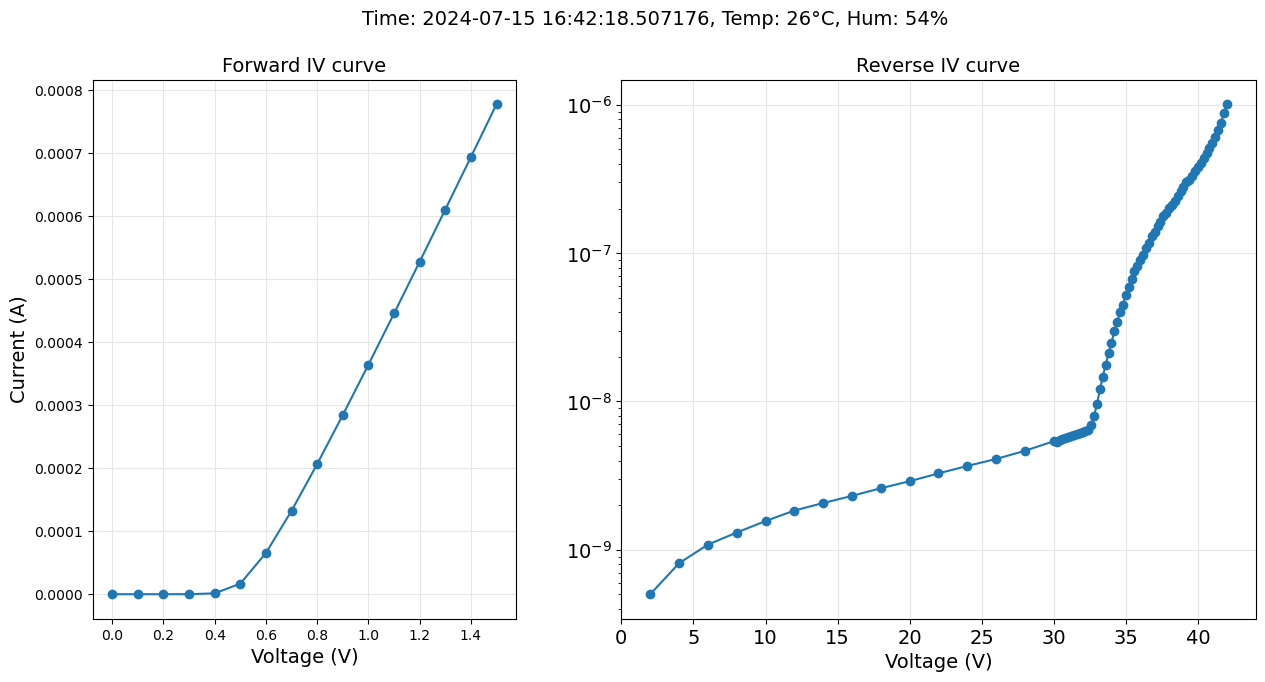

In [7]:
plottingOneIVCurve(df, 16)

In [8]:
file_list=["data/FBK_TILE01_CH00_15.07.2024-16:11:01.txt",
           "data/FBK_TILE01_CH04_15.07.2024-19:46:47.txt",
           "data/FBK_TILE01_CH07_15.07.2024-19:50:52.txt",
           "data/FBK_TILE01_CH09_15.07.2024-16:14:59.txt",
           "data/FBK_TILE01_CH12_15.07.2024-19:54:48.txt",
           "data/FBK_TILE01_CH25_15.07.2024-16:18:38.txt",
           "data/FBK_TILE01_CH27_15.07.2024-16:22:47.txt",
           "data/FBK_TILE01_CH31_15.07.2024-19:58:38.txt",
           "data/FBK_TILE01_CH32_15.07.2024-16:30:20.txt",
           "data/FBK_TILE01_CH35_15.07.2024-16:34:26.txt",
           "data/FBK_TILE01_CH38_15.07.2024-20:02:24.txt",
           "data/FBK_TILE01_CH48_15.07.2024-16:38:21.txt",
           "data/FBK_TILE01_CH52_15.07.2024-20:06:13.txt",
           "data/FBK_TILE01_CH54_15.07.2024-20:10:01.txt",
           "data/FBK_TILE01_CH57_15.07.2024-16:42:11.txt",
           "data/FBK_TILE01_CH60_15.07.2024-20:13:44.txt"]
#
CH_list=["CH00", "CH04", "CH07", "CH09", "CH12", "CH25", "CH27", 
         "CH31", "CH32", "CH35", "CH38", "CH48", "CH52", "CH54", 
         "CH57", "CH60"]
#
print(file_list[0])

data/FBK_TILE01_CH00_15.07.2024-16:11:01.txt


In [9]:
df_new = readingOneFile(file_list[1]) 

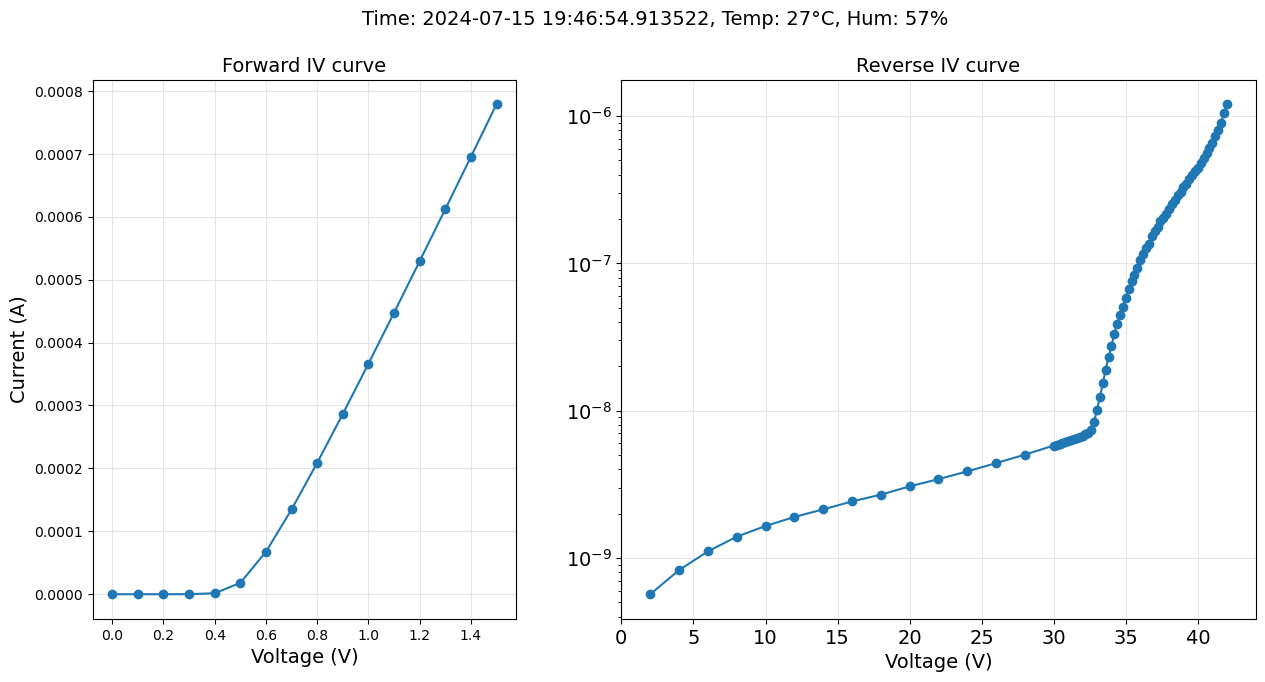

In [10]:
plottingOneIVCurve(df_new, 16)

In [11]:
dfl=[]
for name in file_list:
    if os.path.exists(name):
        dfl.append(readingOneFile(name))
    else:
        dfl.append(np.nan)

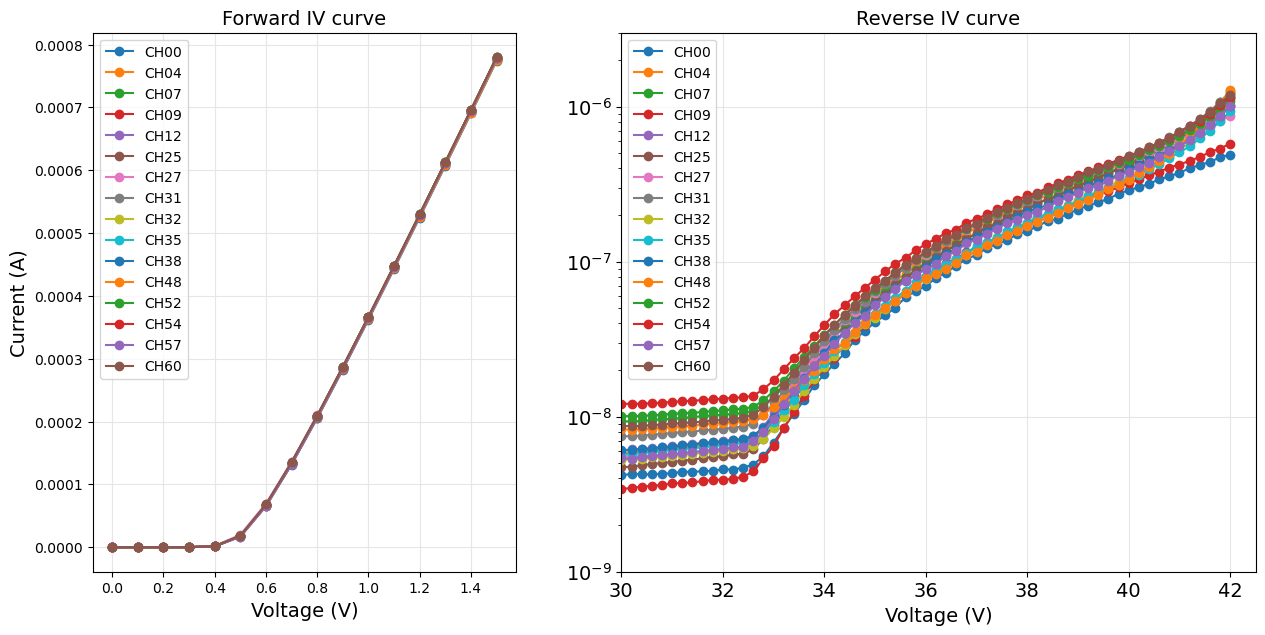

In [12]:
plottingListIVCurve(dfl, 16, CH_list)

In [13]:
dfl_FBK=load_data()

In [14]:
dfl_FBK[0]

,Repeat,VAR2,Point,CH1 Voltage,CH1 Current,CH1 Time
0,1,1,1,0.0,-3.006000e-11,0.042309
1,1,1,2,0.2,9.397000e-11,0.094189
2,1,1,3,0.4,1.436000e-10,0.144504
3,1,1,4,0.6,1.788100e-10,0.240695
4,1,1,5,0.8,2.342200e-10,0.290376
...,...,...,...,...,...,...
206,1,1,207,41.2,3.428770e-06,8.990260
207,1,1,208,41.4,3.986900e-06,8.994660
208,1,1,209,41.6,3.701690e-06,9.001580
209,1,1,210,41.8,4.395240e-06,9.006050


3.832723618009479e-07
1.392923357582938e-06


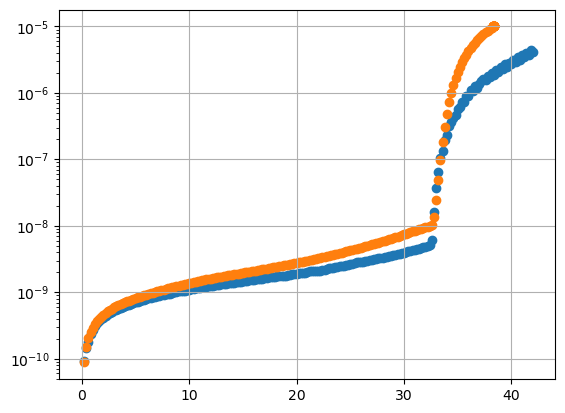

In [15]:
vmin=-1.0
vmax=50.0
#
df0=dfl_FBK[0]
df1=dfl_FBK[8]
x=df0[(df0['CH1 Voltage']>vmin) & (df0['CH1 Voltage']<vmax)]['CH1 Voltage']
y=df0[(df0['CH1 Voltage']>vmin) & (df0['CH1 Voltage']<vmax)]['CH1 Current']
plt.scatter(x=x,y=y)
plt.yscale('log')
plt.grid(True)
print(np.mean(y))
#
x=df1[(df1['CH1 Voltage']>vmin) & (df1['CH1 Voltage']<vmax)]['CH1 Voltage']
y=df1[(df1['CH1 Voltage']>vmin) & (df1['CH1 Voltage']<vmax)]['CH1 Current']
plt.scatter(x=x,y=y)
plt.yscale('log')
plt.grid(True)
print(np.mean(y))

2.7244574999999997e-07
1.350171875e-07


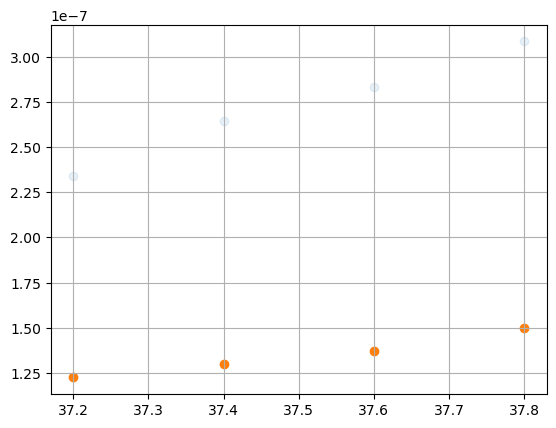

In [16]:
one_only = 1

for i in np.arange(40,41):
    vmin=37.0
    vmax=38.0
    #
    df0=dfl_FBK[i]
    x=df0[(df0['CH1 Voltage']>vmin) & (df0['CH1 Voltage']<vmax)]['CH1 Voltage']
    y=df0[(df0['CH1 Voltage']>vmin) & (df0['CH1 Voltage']<vmax)]['CH1 Current']
    plt.scatter(x=x,y=y,alpha=0.1)
    #plt.yscale('log')
    plt.grid(True)
    print(np.mean(y))
        
    if (one_only == 1):
        #
        df1=dfl[0]['VI_table']
        x=np.abs(df1[(df1['Sourced_voltage']>vmin) & (df1['Sourced_voltage']<vmax)]['Sourced_voltage'])
        y=np.abs(df1[(df1['Sourced_voltage']>vmin) & (df1['Sourced_voltage']<vmax)]['Current_Average'])
        plt.scatter(x=x,y=y,alpha=1.0)
        #plt.yscale('log')
        plt.grid(True)
        print(np.mean(y))
        one_only=2

In [17]:
for i in np.arange(0,63):
    vmin=37.0
    vmax=38.0
    #
    df0=dfl_FBK[i]
    x=df0[(df0['CH1 Voltage']>vmin) & (df0['CH1 Voltage']<vmax)]['CH1 Voltage']
    y=df0[(df0['CH1 Voltage']>vmin) & (df0['CH1 Voltage']<vmax)]['CH1 Current']
    df0_y_mean = np.mean(y)
    #
    df1=dfl[0]['VI_table']
    x=np.abs(df1[(df1['Sourced_voltage']>vmin) & (df1['Sourced_voltage']<vmax)]['Sourced_voltage'])
    y=np.abs(df1[(df1['Sourced_voltage']>vmin) & (df1['Sourced_voltage']<vmax)]['Current_Average'])
    print(i," ",(df0_y_mean-np.mean(y))/df0_y_mean)  

0   0.917693826176859
1   0.5134261519971315
2   0.48501758822480506
3   0.41461102060415295
4   0.3399903333113359
5   0.35366127018594007
6   0.885875330443952
7   0.8717608906259646
8   0.9828452447354311
9   0.33673282037375996
10   0.3813610043585588
11   0.36781493148103284
12   0.346655726559419
13   0.6888562197501604
14   0.8721482630948492
15   0.890187075037413
16   0.4596286420395422
17   0.4631912893000806
18   0.4162725206359226
19   0.9329018790051858
20   0.3314875454654383
21   0.2758618493474872
22   0.9071577824536794
23   0.825930941413235
24   0.8285077917409704
25   0.9185938500960923
26   0.9534940829615056
27   0.9161779610246096
28   0.9198755751904643
29   0.8414860057298449
30   0.8599886060788319
31   0.8339431813604656
32   0.8982083654533015
33   0.8655307745935313
34   0.9125277162760339
35   0.9462128455260262
36   0.8391023440995913
37   0.8527068409072016
38   0.8642893309813146
39   0.8445340674613226
40   0.5044254223088449
41   0.1746535514415744
42

In [18]:
df1

,Sourced_voltage,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,Current_Average
0,-1.5,7.738040e-04,7.738010e-04,7.738080e-04,7.738070e-04,7.738130e-04,7.738110e-04,7.738000e-04,7.738030e-04,7.738130e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.738069e-04
1,-1.4,6.903410e-04,6.903310e-04,6.903400e-04,6.903330e-04,6.903380e-04,6.903420e-04,6.903380e-04,6.903400e-04,6.903320e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.903380e-04
2,-1.3,6.072570e-04,6.072670e-04,6.072730e-04,6.072610e-04,6.072550e-04,6.072580e-04,6.072670e-04,6.072780e-04,6.072580e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.072643e-04
3,-1.2,5.247420e-04,5.247440e-04,5.247430e-04,5.247360e-04,5.247360e-04,5.247390e-04,5.247340e-04,5.247400e-04,5.247380e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.247395e-04
4,-1.1,4.429110e-04,4.429100e-04,4.429120e-04,4.429080e-04,4.429070e-04,4.429080e-04,4.429110e-04,4.428980e-04,4.429100e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.429086e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,41.2,-4.106150e-07,-4.063020e-07,-4.067600e-07,-3.848650e-07,-4.028920e-07,-4.020060e-07,-3.828860e-07,-3.991790e-07,-4.206820e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.001338e-07
87,41.4,-4.318840e-07,-4.195790e-07,-4.226100e-07,-4.234570e-07,-4.225200e-07,-4.175190e-07,-4.153070e-07,-4.249410e-07,-4.191630e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.206370e-07
88,41.6,-4.309660e-07,-4.252780e-07,-4.579470e-07,-4.342540e-07,-4.302650e-07,-4.446010e-07,-4.613450e-07,-4.491810e-07,-4.321650e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.398101e-07
89,41.8,-4.924770e-07,-4.674640e-07,-4.642350e-07,-4.625430e-07,-4.550490e-07,-4.544620e-07,-4.926870e-07,-4.799730e-07,-4.696360e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.711309e-07
